In [1]:
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re
import math
import datetime
import random
import copy
from tqdm import tqdm

#import category_encoders as ce
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#import train and test datasets
train1 = pd.read_csv('/home/felix/Downloads/zimnat/Train.csv', parse_dates = ['join_date'])
test1 = pd.read_csv('/home/felix/Downloads/zimnat/Test.csv', parse_dates=['join_date'])
submission = pd.read_csv('/home/felix/Downloads/zimnat/SampleSubmission.csv')

In [3]:
# Split features and labels
train1_labels = train1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)
train1_features = train1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_features = test1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_labels = test1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train1_features, test1_features]).reset_index(drop=True)
print(all_features.shape, train1_labels.shape, test1_labels.shape)

(39132, 8) (29132, 21) (10000, 21)


In [4]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:9]

Percent of missing data


[('join_date', 0.01),
 ('ID', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [5]:
def handl_miss(df):
    df['join_date'] = df.groupby('branch_code')['join_date'].transform(lambda x: x.fillna(x.mode()[0]))
    return df


all_features = handl_miss(all_features)    

In [6]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('ID', 0.0),
 ('join_date', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [7]:
all_features['age'] = 2020 - all_features['birth_year']
all_features['join_year'] = all_features['join_date'].dt.year
all_features['join_month'] = all_features['join_date'].dt.month
all_features['join_day'] = all_features['join_date'].dt.day

dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
all_features['time_period'] = dt - all_features['join_date']

all_features['ageWJ'] = all_features['join_date'].dt.year - all_features['birth_year']
all_features['year_num'] = 2020 - all_features['join_year']

all_features['time_period'] = all_features['time_period'].astype(str)
all_features['time_period'] = all_features['time_period'].str.extract('(\d+)').astype(int)
all_features['yr_0'] = all_features['time_period'] / 365

In [8]:
def logs(res, ls):
    m =res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['birth_year', 'age', 'ageWJ']

all_features = logs(all_features, log_features)

In [9]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res

squared_features = ['birth_year', 'age', 'ageWJ']
all_features = squares(all_features, squared_features)

In [10]:
all_features = all_features.loc[:, ~all_features.columns.duplicated()]

In [11]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

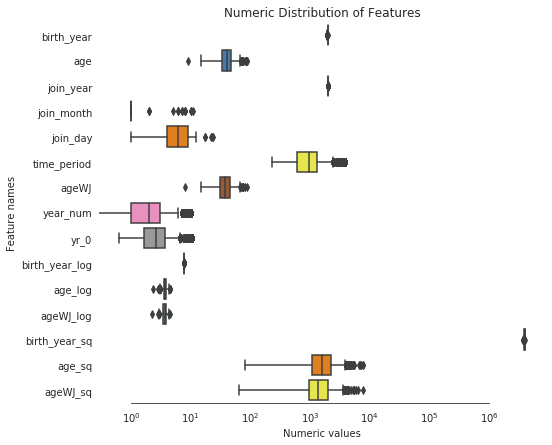

In [12]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [13]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: x.skew()).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(20)

There are 6 numerical features with Skew > 0.5 :


join_month        65.106593
yr_0               1.500776
time_period        1.500776
year_num           1.496821
age_sq             0.744270
ageWJ_sq           0.734483
ageWJ              0.247440
age                0.246128
join_day           0.166672
birth_year_sq     -0.235857
ageWJ_log         -0.244608
birth_year        -0.246128
age_log           -0.253791
birth_year_log    -0.256419
join_year         -1.496821
dtype: float64

In [14]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [15]:
X_train__ = all_features.iloc[:len(train1_labels), :]
X_test__ = all_features.iloc[len(train1_labels):, :]
X_train__.shape, train1_labels.shape, X_test__.shape, test1_labels.shape

((29132, 22), (29132, 21), (10000, 22), (10000, 21))

In [16]:
train = pd.concat([X_train__, train1_labels], axis=1)

In [17]:
X_test__ = X_test__.reset_index(drop=True)
test = pd.concat([X_test__, test1_labels], axis=1)

In [18]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.727138,32,0.716661,0.916033,7.594889,3.526655,3.496811,3948169,17.993312,17.108779,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.701040,38,0.716661,0.912396,7.591867,3.689129,3.663818,3924361,19.828467,18.875782,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,0.152703,6,20.849586,22,2.300857,1.877075,7.596899,3.401531,3.135929,3964081,16.670900,13.710478,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,0.152703,8,13.687941,29,0.716661,0.910571,7.596397,3.434310,3.401531,3960100,17.010007,16.158098,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,0.152703,8,13.687941,29,0.716661,0.910571,7.596397,3.434310,3.401531,3960100,17.010007,16.158098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [19]:
test.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,2018-01-12,M,M,1984,94KC,DZRV,90QI,36,2018,0.152703,12,15.637642,34,1.158462,1.184835,7.593379,3.611188,3.555634,3936256,18.930908,17.716170,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,24,2019,0.152703,10,13.674806,23,0.716661,0.908742,7.599406,3.219276,3.178470,3984016,14.875667,14.083468,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,52,2020,0.152703,1,10.437956,52,0.000000,0.488836,7.585286,3.970481,3.970481,3873024,23.352495,22.485918,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,2019-01-02,M,M,1989,94KC,2A7I,T4MS,31,2019,0.152703,2,13.727138,30,0.716661,0.916033,7.595895,3.466048,3.434310,3956121,17.343259,16.480624,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,2020-01-02,F,M,1982,UAOD,0KID,T4MS,38,2020,0.152703,2,10.424518,38,0.000000,0.487289,7.592371,3.663818,3.663818,3928324,19.533426,18.875782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [20]:
#print all dataset shape
print(train.shape, test.shape,submission.shape)

(29132, 43) (10000, 43) (210000, 2)


In [21]:
train.columns

Index(['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], dtype='object')

In [22]:
X_train = []
X_train_columns = train.columns
c = 0
for v in train.values:
  info = v[:22]
  binary = v[22:]
  index = [k for k, i in enumerate(binary) if i == 1]
  for i in index:
    c+=1
    for k in range(len(binary)):
      if k == i:
        binary_transformed = list(copy.copy(binary))
        binary_transformed[i] = 0
        X_train.append(list(info) + binary_transformed + [X_train_columns[22+k]] + [c])

X_train = pd.DataFrame(X_train)
X_train.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'product_pred', 'ID2']

In [23]:
X_test = []
true_values = []
c = 0
for v in test.values:
  c += 1
  info = v[:22]
  binary = v[22:]
  index = [k for k, i in enumerate(binary) if i == 1]
  X_test.append(list(info) + list(binary) + [c])
  for k in test.columns[22:][index]:
    true_values.append(v[0] + ' X ' + k)

X_test = pd.DataFrame(X_test)
X_test.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'ID2']

In [24]:
features_train = []
features_test = []
columns = []

append_features = ['ID', 'ID2', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']
for v in append_features:
  features_train.append(X_train[v].values.reshape(-1, 1))
  features_test.append(X_test[v].values.reshape(-1, 1))
  columns.append(np.array([v]))

y_train = X_train[['product_pred']]

In [25]:
features_train = np.concatenate(features_train, axis=1)
features_test = np.concatenate(features_test, axis=1)
columns = np.concatenate(np.array(columns))

X_train = pd.DataFrame(features_train)
X_train.columns = columns
X_test = pd.DataFrame(features_test)
X_test.columns = columns

In [26]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)

In [27]:
X_train.drop('join_date', axis=1, inplace=True)
X_test.drop('join_date', axis=1, inplace=True)

In [28]:
X_train.head()

,ID,ID2,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.727138,32,0.716661,0.916033,7.594889,3.526655,3.496811,3948169,17.993312,17.108779,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4WKQSBB,2,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.727138,32,0.716661,0.916033,7.594889,3.526655,3.496811,3948169,17.993312,17.108779,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CP5S02H,3,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.701040,38,0.716661,0.912396,7.591867,3.689129,3.663818,3924361,19.828467,18.875782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,CP5S02H,4,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.701040,38,0.716661,0.912396,7.591867,3.689129,3.663818,3924361,19.828467,18.875782,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2YKDILJ,5,M,U,1991,748L,QZYX,90QI,29,2013,0.152703,6,20.849586,22,2.300857,1.877075,7.596899,3.401531,3.135929,3964081,16.670900,13.710478,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [29]:
y_train.head()

,product_pred
0,RVSZ
1,K6QO
2,RVSZ
3,K6QO
4,SOP4


In [30]:
X_test.head()

,ID,ID2,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,1,M,M,1984,94KC,DZRV,90QI,36,2018,0.152703,12,15.637642,34,1.158462,1.184835,7.593379,3.611188,3.555634,3936256,18.930908,17.716170,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,2,M,M,1996,1X1H,J9SY,90QI,24,2019,0.152703,10,13.674806,23,0.716661,0.908742,7.599406,3.219276,3.178470,3984016,14.875667,14.083468,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,3,F,W,1968,UAOD,2A7I,T4MS,52,2020,0.152703,1,10.437956,52,0.000000,0.488836,7.585286,3.970481,3.970481,3873024,23.352495,22.485918,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,4,M,M,1989,94KC,2A7I,T4MS,31,2019,0.152703,2,13.727138,30,0.716661,0.916033,7.595895,3.466048,3.434310,3956121,17.343259,16.480624,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,5,F,M,1982,UAOD,0KID,T4MS,38,2020,0.152703,2,10.424518,38,0.000000,0.487289,7.592371,3.663818,3.663818,3928324,19.533426,18.875782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [31]:
X_test.columns

Index(['ID', 'ID2', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], dtype='object')

In [32]:
X_train.shape, y_train.shape, X_test.shape

((66353, 43), (66353, 1), (10000, 43))

In [33]:
le = LabelEncoder()
le.fit(y_train.iloc[:,0])
y_train = pd.DataFrame(le.transform(y_train.iloc[:,0]))
y_train.columns = ['target']

In [38]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).drop(['ID'], axis=1).columns

In [ ]:
model = LogisticRegression()
encoder = ce.woe.WOEEncoder
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('woe', encoder())])
    
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),('cat', categorical_transformer, cat_features)])
    
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('m', model)])


cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate log_loss
scores = cross_val_score(pipe, X_train.drop(columns=['ID', 'ID2']), y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
# summarize the model performance
print('Log_Loss: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
proba = pipeline.predict_proba(X_test.drop(columns=['ID','ID2'], axis=1))
y_test = pd.DataFrame(proba)
y_test.columns = le.inverse_transform(y_test.columns)

In [ ]:
answer_mass = []
for i in range(X_test.shape[0]):
  id = X_test['ID'].iloc[i]
  for c in y_test.columns:
    answer_mass.append([id + ' X ' + c, y_test[c].iloc[i]])

df_answer = pd.DataFrame(answer_mass)
df_answer.columns = ['ID X PCODE', 'Label']
for i in range(df_answer.shape[0]):
  if df_answer['ID X PCODE'].iloc[i] in true_values:
    df_answer['Label'].iloc[i] = 1.0

In [ ]:
df_answer.reset_index(drop=True, inplace=True)
df_answer.to_csv('/home/felix/Downloads/zimnat/zinmat_submission2.csv', index=False)

# DO NOT CROSS

 ENCODE CATEGORICAL FEATURES

In [ ]:
# encode categorical variables
#from sklearn.preprocessing import OneHotEncoder
#ohc = OneHotEncoder()
#ohe = ohc.fit_transform(train.sex.values.reshape(-1,1)).toarray()
#dfOneHot = pd.DataFrame(ohe, columns=['sex'+str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])

#train = pd.concat([train, dfOneHot], axis=1)
#train.head()

In [ ]:
#train
#binary
import category_encoders as ce
bin_enc = ce.BinaryEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfbin = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)

#leaveoneout
loo_enc = ce.LeaveOneOutEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfloo = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#james-stein
js_enc = ce.JamesSteinEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfjs = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#m-estimate
me_enc = ce.MEstimateEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfme = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#target
te_enc = ce.TargetEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfte = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#woe
woe_enc = ce.WOEEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfwoe = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)
df

In [ ]:
train.head()

In [ ]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Oranges", square=True)

In [ ]:
encoder_list = [ce.binary.BinaryEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.woe.WOEEncoder
                ]
for encoder in encoder_list:
    
    numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
    ('woe', encoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=500))])
    
    model = pipe.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(encoder)
    print(f1_score(y_test, y_pred, average='macro'))
    
    
    
    

    
encoder = ce.woe.WOEEncoder
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('woe', encoder())])
    
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])
    
pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(n_estimators=500))])
    
model = pipe.fit(X_train, y_train)


In [ ]:
model = LogisticRegression()
encoder = ce.woe.WOEEncoder
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('woe', encoder())])
    
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])
    
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('m', model)])


cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate log_loss
scores = cross_val_score(pipe, X_train.drop(columns=['ID', 'ID2']), y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
# summarize the model performance
print('Log_Loss: %.3f (%.3f)' % (mean(scores), std(scores)))







model = LogisticRegression()
# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
# define the model cross-validation configuration
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
# summarize the model performance
print('Log_Loss: %.3f (%.3f)' % (mean(scores), std(scores)))